In [1]:
%pylab inline
import seaborn as sns
from prody import *
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
pdbid = '5pnt'
n = 158
#how to choose the correct value for n?

##Build kirchoff matrix using EVfold contacts

In [3]:
def build_kirchhoff(n):
    chain = []
    chain_connection = np.zeros((n,n))
    
    #assign a -1 for residues in contact in the chain
    for i in range(2, n-2):
        chain_connection[i, i+1] = -1
        chain_connection[i, i+2] = -1
        #chain_connection[i, i+3] = -1
        chain_connection[i+1, i] = -1
        chain_connection[i+2, i] = -1
        #chain_connection[i+3, i] = -1
        chain_connection[i, i-1] = -1
        chain_connection[i, i-2] = -1
        #chain_connection[i, i-3] = -1
        chain_connection[i-1, i] = -1
        chain_connection[i-2, i] = -1
        #chain_connection[i-3, i] = -1
        
        chain.append([i, i+1, chain_connection[i, i+1]])
        chain.append([i, i+2, chain_connection[i, i+2]])
        #chain.append([i, i+3, chain_connection[i, i+3]])
        chain.append([i+1, i, chain_connection[i+1, i]])
        chain.append([i+2, i, chain_connection[i+2, i]])
        #chain.append([i+3, i, chain_connection[i+3, i]])
        chain.append([i, i-1, chain_connection[i, i-1]])
        chain.append([i, i-2, chain_connection[i, i-2]])
        #chain.append([i, i-3, chain_connection[i, i-3]])
        chain.append([i-1, i, chain_connection[i-1, i]])
        chain.append([i-2, i, chain_connection[i-2, i]])
        #chain.append([i-3, i, chain_connection[i-3, i]])
        
    #assign a -1 for EC pairs
    evol = []
    contact_pairs = open('5pnt_MI_DI.txt', 'rU').readlines()
    evol_const = np.zeros((n,n))
    for line in contact_pairs:
        a = line.split()
        i = int(a[0])
        j = int(a[2])
        if (chain_connection[i, j] != -1):
            evol_const[i, j] = -1.0*float(a[5])
            evol_const[j, i] = -1.0*float(a[5])
            evol.append([i, j, evol_const[i, j]])
            evol.append([j, i, evol_const[j, i]])
    
    #build kirchoff matrix
    kirchhoff = np.zeros((n,n))
    kirchhoff = chain_connection + evol_const
    print 'generated kirchhoff using evolutionary constraints'
    print 'kirchhoff shape: ', kirchhoff.shape
    
    #calculate the diagonal
    diag = []
    for i in range(0, n):
        kirchhoff[i, i] = -np.sum(kirchhoff[i])
        diag.append([i, i, kirchhoff[i, i]])
    
    #put everything together for a file
    all = chain + evol + diag
    f = open('evfold_kirchhoff.txt', 'w')
    for x in all:
        f.write('%s \t %s \t %s \n' % (x[0], x[1], x[2]))
    f.close()
    
    return kirchhoff;
build_kirchhoff(n)

generated kirchhoff using evolutionary constraints
kirchhoff shape:  (158, 158)


array([[ 1.        ,  0.        , -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  2.        , -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.        , -1.        ,  4.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  4.57271483,
        -1.        , -1.        ],
       [ 0.        ,  0.        ,  0.        , ..., -1.        ,
         2.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -1.        ,
         0.        ,  1.        ]])

##Calculate square fluctuations using evfold kirchoff 

In [4]:
#get square fluctuations using custom kirchoff matrix 
sqf = open('sqflucts_evfold.txt', 'w')
kirchhoff = parseSparseMatrix('evfold_kirchhoff.txt', symmetric=True)
#print 'kirchhoff dimensions: ', kirchhoff.shape
gnm3 = GNM('GNM for RASH_HUMAN (5p21)')
gnm3.setKirchhoff(kirchhoff)
gnm3.calcModes()
sqflucts = calcSqFlucts(gnm3[:])
for x in sqflucts:
    sqf.write('%s \n' % (x))
sqf.close()

@> 20 modes were calculated in 0.00s.
DEBUG:.prody:20 modes were calculated in 0.00s.


##Calculate square fluctuations using ProDy matrix

In [5]:
sqf1 = open('sqflucts_ProDy.txt', 'w')
cal = parsePDB(pdbid)
calphas = cal.select('calpha and chain A')
gnm1 = GNM('kirchhoff from ProDy')
gnm1.buildKirchhoff(calphas)
gnm1.getKirchhoff()
gnm1.calcModes()
sqflucts1 = calcSqFlucts(gnm1[:])
for x in sqflucts1:
    sqf1.write('%s \n' % (x))
sqf1.close()

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> 5pnt downloaded (5pnt.pdb.gz)
DEBUG:.prody:5pnt downloaded (5pnt.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
@> 1347 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:1347 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
DEBUG:.prody:Kirchhoff was built in 0.01s.
@> 20 modes were calculated in 0.01s.
DEBUG:.prody:20 modes were calculated in 0.01s.


##Calculate b-factors 

In [6]:
bfac1 = open('bfactor_ProDy.txt', 'w')
bfac_exp = open('bfactor_exp.txt', 'w')
bfac_evfold = open('bfactor_evfold.txt', 'w')
bfact1 = calcTempFactors(gnm1[:],calphas) # scaled with exp bfactor
bfact_evfold = calcTempFactors(gnm3[:],calphas)
bfactexp = calphas.getBetas() # experimental bfactor from pdb
for x in bfactexp:
    bfac_exp.write('%s \n' % (x))
bfac_exp.close()
for x in bfact1:
    bfac1.write('%s \n' % (x))
bfac1.close()
for x in bfact_evfold:
    bfac_evfold.write('%s \n' % (x))
bfac_evfold.close()

##Calculate correlation coefficients

In [7]:
correlation1 = corrcoef(bfact1,bfactexp) # ProDy w. Exp
d1 = correlation1.round(2)[0,1]
print 'correlation (ProDy vs. exp): ',d1

correlation8 = corrcoef(bfact_evfold,bfactexp) # EVfold w. Exp
d8 = correlation8.round(2)[0,1]
print 'correlation (EVfold vs. exp): ',d8

correlation9 = corrcoef(bfact_evfold,bfact1) # EVfold w. ProDy
d9 = correlation9.round(2)[0,1]
print 'correlation (EVfold vs. ProDy): ',d9

correlation (ProDy vs. exp):  0.68
correlation (EVfold vs. exp):  0.68
correlation (EVfold vs. ProDy):  0.43


##Plot the b-factors 

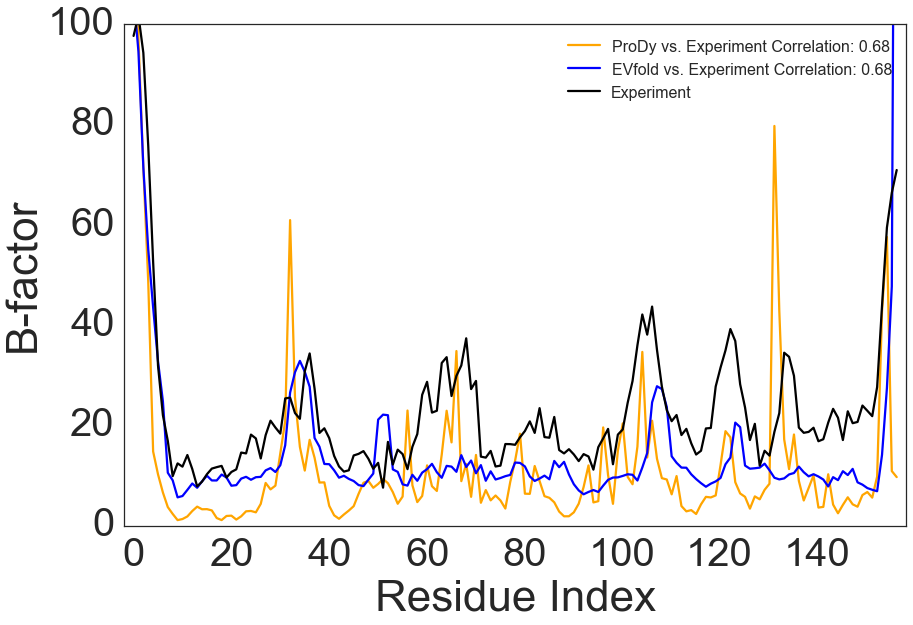

In [8]:
sns.set_style('white')
sns.set_context("poster", font_scale=2.5, rc={"lines.linewidth": 2.25, "lines.markersize": 8 })
plt.plot(bfact1, color="orange", label='ProDy vs. Experiment Correlation: %0.2f' % d1)
plt.plot(bfact_evfold, color="blue", label='EVfold vs. Experiment Correlation: %0.2f' % d8)
plt.plot(bfactexp, color="black", label='Experiment')
plt.xlabel('Residue Index')
plt.ylabel('B-factor')
plt.xlim(-2.0,n)
plt.ylim(0,100)
plt.legend(loc="upper right",fontsize='large')
legend(loc=1,prop={'size':16})
plt.tight_layout()
plt.savefig(pdbid+'-bfactors.png')